# Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import math
import time
import pickle

#TURN 1 FOR DEFENDERS, -1 FOR ATTACKERS

# Game Rules Implementation

The following block of codes implements the rules of the game.

- _isLegal_ checks whether if the move _p1_ -> _p2_ is allowed in _board_: is there a pawn of the right side on _p1_, is _p2_ empty and is there a straight, unblocked path between the two.
- _listOfMoves_ iterates through all the possible moves, and checks whether each one is legal or not using _isLegal_. Then, it returns a list of valid moves.
- _kingCaptured_ checks in all the possible ways if the king has been captured.
- _checkEndgame_ verifies if the king has been captured, or if it has reached the corners, or if there are no attackers left on the board
- _mightEat_ takes a move as input, and checks whether this move results in one or more piece being eaten. It returns 'eating' information, and the updated board.

In [2]:
def isLegal(board, p1, p2, turn):

    #check if p2 is free
    if board[p2[0]][p2[1]] != 0:
        return False

    #check if p1 has a pawn of the right side
    if (turn==1 and board[p1[0]][p1[1]] not in [1, 2]) or (turn==-1 and board[p1[0]][p1[1]]!=3):
        return False

    #check if both positions are on either the same line or the same column
    if p1[0]!= p2[0] and p1[1]!=p2[1]:
        return False

    #check that they are not the same position
    if p1[0]== p2[0] and p1[1]==p2[1]:
        return False

    #check that no one is in a hostile square (except for a king in the corner)
    if board[p1[0]][p1[1]]!=2 and p2 in [[0,0],[0,6],[6,0],[6,6],[3,3]]:
        return False
    elif p2 in [[3,3]]:
        return False

    #check that all the slots between the two positions are empty, to allow a free passage
    moving_axis=int(p1[0]==p2[0])
    direction=int((int(p2[moving_axis]-p1[moving_axis]>0)-0.5)*2)
    for i in range(abs(p1[0]-p2[0]+p1[1]-p2[1])):
        if board[p1[0]+(1-moving_axis)*(i+1)*direction][p1[1]+(moving_axis)*(i+1)*direction]!=0:
            return False

    return True

def listOfMoves(board, turn):

    list_of_moves=[]

    available_pawns=[]

    #check available moves for the attacker (turn=-1)
    if turn==-1:
        rawpawns=np.where(np.array(board)==3)

        #iterate through all the attackers
        for i in range(rawpawns[0].size):
            this_pawn=[rawpawns[0][i], rawpawns[1][i]]

            #check legality of a move to every square in a cross around the pawn 
            for j in range(7):
                if isLegal(board, this_pawn, [this_pawn[0],j], -1):
                    list_of_moves+=[[this_pawn, [this_pawn[0],j]]]
            for k in range(7):
                if isLegal(board, this_pawn, [k, this_pawn[1]], -1):
                    list_of_moves+=[[this_pawn, [k, this_pawn[1]]]]
    
    #check available moves for the defender (turn=1)
    elif turn==1:
        a=np.where(np.array(board)==1)
        b=np.where(np.array(board)==2)
        rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

        #iterate through all the defender
        for i in range(len(rawpawns[0])):
            this_pawn=[rawpawns[0][i], rawpawns[1][i]]

            #check legality of a move to every square in a cross around the pawn 
            for j in range(7):
                if isLegal(board, this_pawn, [this_pawn[0],j], 1):
                    list_of_moves+=[[this_pawn, [this_pawn[0],j]]]
            for k in range(7):
                if isLegal(board, this_pawn, [k, this_pawn[1]], 1):
                    list_of_moves+=[[this_pawn, [k, this_pawn[1]]]]
    
    #return a list of available moves
    return list_of_moves

In [3]:
def kingCaptured(board):
    coordinates_raw=np.where(np.array(board)==2)
    coordinates=[int(coordinates_raw[0]),int(coordinates_raw[1])]

    checks=[[0,1],[1,0],[0,-1],[-1,0]]

    surrounded=4
    first_opponent=False
    first_opponent_dir=-1

    #check whether the king is in the center
    if coordinates in [[3,3]]:
        #return the capture if the king is surrounded on all sides
        if board[2][3]==3 and board[3][2]==3 and board[4][3]==3 and board[3][4]==3:
            return [True, -1]
        return [False, 0]

    #check whether the king is adjacent to the throne
    elif coordinates in [[2,3],[3,2],[4,3],[3,4]]:

        #check whether the king is surrounded by three players (we know no one is on the throne because no legal moves allow it)
        for i in range(4):
            if coordinates[0]+checks[i][0]<7 and coordinates[0]+checks[i][0]>-1 and coordinates[1]+checks[i][1]<7 and coordinates[1]+checks[i][1]>-1:
                if board[coordinates[0]+checks[i][0]][coordinates[1]+checks[i][1]]!=3:
                    surrounded=surrounded-1
        if surrounded==3:
            return [True, -1]
        return [False, 0]
    
    #check if the king has two attackers around itself
    for i in range(2):
        if 0<=coordinates[0]+checks[i][0]<=6 and 0<=coordinates[1]+checks[i][1]<=6 and 0<=coordinates[0]+checks[i+2][0]<=6 and 0<=coordinates[1]+checks[i+2][1]<=6:
            if board[coordinates[0]+checks[i][0]][coordinates[1]+checks[i][1]]==3 and board[coordinates[0]+checks[i+2][0]][coordinates[1]+checks[i+2][1]]==3:
                return [True, -1]
                
    return [False, 0]

#check if the king is in the corner, if there are no attackers left, or if the king is captured
def checkEndgame(board, turn):
    if board[0][0]==2 or board[0][6]==2 or board[6][0]==2 or board[6][6]==2:
        return [True, 1]
    if np.where(np.array(board)==3)[0].size==0:
        return [True, 1]
    if turn==-1:
        return kingCaptured(board)
    else:
        return [False, 0]

In [4]:
def mightEat(board, p2, turn):

    eaten=0

    coordinates_raw=np.where(np.array(board)==2)

    checks=[[0,1],[1,0],[0,-1],[-1,0]]
    two_step=[[0,2],[2,0],[0,-2],[-2,0]]
    dir=['right','up','left','down']

    #check if there is an enemy player next to the p2 of the new move, and if there is a hostile square or a friendly piece on the other side of this enemy piece
    for i in range(4):
        if 0 <= p2[0]+two_step[i][0] <= 6 and 0 <= p2[1]+two_step[i][1] <= 6:
            if board[p2[0]+checks[i][0]][p2[1]+checks[i][1]]==2+turn and (board[p2[0]+two_step[i][0]][p2[1]+two_step[i][1]]==2-turn or [p2[0]+two_step[i][0],p2[1]+two_step[i][1]] in [[0,0],[0,6],[6,0],[6,6]] or ([p2[0]+two_step[i][0],p2[1]+two_step[i][1]] in [[3, 3]] and turn==-1 and board[3][3]!=2) or ([p2[0]+two_step[i][0],p2[1]+two_step[i][1]] in [[3, 3]] and turn==1) or (board[p2[0]+two_step[i][0]][p2[1]+two_step[i][1]]==2 and turn==1)):
                board[p2[0]+checks[i][0]][p2[1]+checks[i][1]]=0
                eaten+=1
    
    return board, eaten

# Game Class

The following class defines a game with its board, information on who plays next (turn) and whether the game is over or not.
It has different types of moves for different usages.

In [5]:
class Game():

    #init class with the beginning board, over set to 0 (False) and turn set to attackers
    def __init__(self):
        init_board=[[0,0,0,3,0,0,0],[0,0,0,3,0,0,0],[0,0,0,1,0,0,0],[3,3,1,2,1,3,3],[0,0,0,1,0,0,0],[0,0,0,3,0,0,0],[0,0,0,3,0,0,0]]
        self.over=0
        self.board=init_board
        self.turn=-1

    #start an existing game from scratch: useful to avoid creating a high number of data structures that will only be used once
    def reset(self):
        init_board=[[0,0,0,3,0,0,0],[0,0,0,3,0,0,0],[0,0,0,1,0,0,0],[3,3,1,2,1,3,3],[0,0,0,1,0,0,0],[0,0,0,3,0,0,0],[0,0,0,3,0,0,0]]
        self.over=0
        self.board=init_board
        self.turn=-1

    #allows a game to start from an existing position
    def preloardBoard(self, new_board, new_turn):
        self.board=copy.deepcopy(new_board)
        self.turn=new_turn

    #human move function, that checks if the move is legal. In practice, I didn't use this function in my trials
    def human_move(self, pos1, pos2):
        p1=[(pos1//10)-1,(pos1%10)-1]
        p2=[(pos2//10)-1,(pos2%10)-1]
        if not isLegal(self.board, p1,  p2, self.turn):
            print('ILLEGAL MOVE')
            return 
             
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board=mightEat(self.board, p2, self.turn)
        self.turn=-self.turn
        return checkEndgame(self.board, -self.turn)

    #this function plays a move on a board. It assumes that the move was played by an agent that already checks for 
    #legal moves, so it doesn't check them
    def AImove(self, p1, p2):
        if p1 in [[10,10]]:
            return [True, -self.turn]
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board, eaten=mightEat(self.board, p2, self.turn)
        self.turn=-self.turn
        return checkEndgame(self.board, -self.turn)

    #works the same as the function above, but reaturn whether pieces have been eaten. I planned on using piece eating
    #as reward, but ended up not doing so
    def RewardMove(self, p1, p2):
        if p1 in [[10,10]]:
            return [True, -self.turn]
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board, eaten=mightEat(self.board, p2, self.turn)
        self.turn=-self.turn
        return checkEndgame(self.board, -self.turn), eaten

    #returns the result of one single move, without updating the turn or other information (assumes no other move will be played)
    #useful to compute what the board would look like after a potential move
    def SimuMove(self, p1, p2):
        if p1[0]<0 or p1[0]>6:
            return True, -self.turn, self.board
        self.board[p2[0]][p2[1]]=self.board[p1[0]][p1[1]]
        self.board[p1[0]][p1[1]]=0
        self.board, eaten=mightEat(self.board, p2, self.turn)
        return checkEndgame(self.board, self.turn), eaten, self.board

    #display a board 
    def disp(self):
        print(' ')
        for line in self.board:
            print(line)


The following blocks define two first players: a random player, and a human player.

For a player to work properly, it needs a function _moveChoice()_ which, given a board and a turn, will choose the next move according to that player's policy. If there are no possible moves available, these functions return [[10,10],[10,10]]. In this case, the Game class will realise there are no moves available yet, and declare the defeat of the corresponding player. 

#### Random Player

In [6]:
class Random_Player():

    def __init__(self):
        self.mode=0
        self.step=0

    def moveChoice(self, board, turn):
        movelist=listOfMoves(board, turn)

        if len(movelist)==0:
            return [[10, 10], [10, 10]]

        #simply choose a random move in all the available ones
        return random.choice(movelist)

#### Human Player

In [7]:
class Human_Player():

    def __init__(self):
        self.mode=0
        self.step=0

    def moveChoice(self, board, turn):

        #ask a player for the move in x1y1,x2y2 format
        move=input('Your move: \n')
        b=move.split(",")
        
        return [[int(b[0])//10, int(b[0])%10],[int(b[1])//10, int(b[1])%10]]

# Heuristic Players — Hugin & Munin

In [8]:
class Hugin():

    #the init class defines a set of weights
    def __init__(self, weights):
        self.weights=weights
        self.step=0
        
    def moveChoice(self, board, turn):

        #establish a list of moves
        checks=[[0,1],[0,-1],[1,0],[-1,0]]
        movelist=listOfMoves(board, -1)
        scores=np.zeros((len(movelist)))

        if len(movelist)==0:
            return [[10, 10], [10, 10]]

        a=np.where(np.array(board)==1)
        b=np.where(np.array(board)==2)
        rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

        nb_enemy=len(rawpawns[0])
        simu=Game()

        #loop across all the possible moves
        for i in range(len(movelist)):
            simu.reset()
            move=movelist[i]
            simu.preloardBoard(board, -1)
            endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
            #if the move results in an immediate victory, return it
            #if the move results in an immediate defeat, set it to score -1
            if endgame[0]:
                if endgame[1]==-1:
                    scores[i]=1
                    return move
                else:
                    scores[i]=-1
                    continue
            
            #number of defenders and attackers
            new_nb_enemy=nb_enemy-eaten
            ours=np.where(np.array(newboard)==3)

            #number of columns and rows covered by attacker pieces
            coverage=len(set(ours[0].tolist()))+len(set(ours[1].tolist()))
            king_surrounded=0

            #how many players is the king surrounded by 
            for j in range(4):
                king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                    if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                        king_surrounded+=1
            
            #how many corner-adjacent blocks are covered by attackers
            protected=0
            corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
            for k in range(8):
                if newboard[corners[k][0]][corners[k][1]]==3:
                    protected+=1

            #return a product of weights and the feature vector
            scores[i]= self.weights[0]*(1-new_nb_enemy/5) + self.weights[1]*(coverage/14) + self.weights[2]*(king_surrounded/4) + self.weights[3]*(protected/8)

        return movelist[np.random.choice(np.flatnonzero(scores == scores.max()))]     

In [9]:
class Munin():

    #the init class defines a set of weights
    def __init__(self, weights):
        self.weights=weights
        self.step=0
        
    def moveChoice(self, board, turn):

        #establish a list of moves
        checks=[[0,1],[0,-1],[1,0],[-1,0]]
        movelist=listOfMoves(board, 1)
        scores=np.zeros((len(movelist)))

        if len(movelist)==0:
            return [[10, 10], [10, 10]]

        nb_enemy=len(np.where(np.array(board)==3)[0])
        simu=Game()

        #loop across all the possible moves
        for i in range(len(movelist)):
            simu.reset()
            move=movelist[i]
            simu.preloardBoard(board, 1)
            endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
            #if the move results in an immediate victory, return it
            #if the move results in an immediate defeat, set it to score -1
            if endgame[0]:
                if endgame[1]==1:
                    scores[i]=1
                    return move
                else:
                    scores[i]=-1
                    continue
            
            #number of defenders
            new_nb_enemy=nb_enemy-eaten


            a=np.where(np.array(newboard)==1)
            b=np.where(np.array(newboard)==2)
            rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

            #number of columns and rows covered by defender pieces
            coverage=len(set(rawpawns[0]))+len(set(rawpawns[1]))
            
            king_surrounded=0

            #how many players is the king surrounded by
            for j in range(4):
                king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                    if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                        king_surrounded+=1


            #check how close the king is from one of corners, and how far from the throne
            cordis=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(6-king_pos[1]),abs(6-king_pos[0])+abs(king_pos[1]),abs(6-king_pos[0])+abs(6-king_pos[1]))
            center_corner_axis=(abs(3-king_pos[0])+abs(3-king_pos[1]))+(6-cordis)

            #return a product of weights and the feature vector
            scores[i]= self.weights[0]*(1-new_nb_enemy/8) + self.weights[1]*(coverage/10) + self.weights[2]*(1-king_surrounded/4) + self.weights[3]*center_corner_axis/12
        return movelist[np.random.choice(np.flatnonzero(scores == scores.max()))]     

# Monte-Carlo Player — Odin

The following block defines the Monte-Carlo Player Odin.

In [10]:
class Odin():

    #define all the parameters of Monte-Carlo Player. How many moves will be checked, how deep, when to stop, and the weight heuristic vectors
    def __init__(self, width, depth, max_runs, all_weights):
        self.width=width
        self.depth=depth
        self.max_runs=max_runs
        self.attack_weights=all_weights[0]
        self.defend_weights=all_weights[1]
        self.step=0

    #return the Hugin/Munin heuristic 
    def returnHeuristic(self, board, turn):
        
        checks=[[0,1],[0,-1],[1,0],[-1,0]]

        #if it is defender's turn, copy the functioning of Munin
        if turn==1:
            
            weights=self.defend_weights
            movelist=listOfMoves(board, 1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            nb_enemy=len(np.where(np.array(board)==3)[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, 1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])

                if endgame[0]:
                    if endgame[1]==1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten


                a=np.where(np.array(newboard)==1)
                b=np.where(np.array(newboard)==2)
                rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]
                coverage=len(set(rawpawns[0]))+len(set(rawpawns[1]))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1


                cordis=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(6-king_pos[1]),abs(6-king_pos[0])+abs(king_pos[1]),abs(6-king_pos[0])+abs(6-king_pos[1]))
                center_corner_axis=(abs(3-king_pos[0])+abs(3-king_pos[1]))+(6-cordis)

                scores[i]= weights[0]*(1-new_nb_enemy/8) + weights[1]*(coverage/10) + weights[2]*(1-king_surrounded/4) + weights[3]*center_corner_axis/12

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))

            #returns the top 'width' moves instead of the first one only 
            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)
            
            return npmoves[topindicies]

        #if it is attacker's turn, copy the functioning of Hugin
        else:

            weights=self.attack_weights
            movelist=listOfMoves(board, -1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            a=np.where(np.array(board)==1)
            b=np.where(np.array(board)==2)
            rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

            nb_enemy=len(rawpawns[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, -1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
                if endgame[0]:
                    if endgame[1]==-1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten
                ours=np.where(np.array(newboard)==3)
                coverage=len(set(ours[0].tolist()))+len(set(ours[1].tolist()))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1

                protected=0
                corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
                for k in range(8):
                    if newboard[corners[k][0]][corners[k][1]]==3:
                        protected+=1


                scores[i]= weights[0]*(1-new_nb_enemy/5) + weights[1]*(coverage/14) + weights[2]*(king_surrounded/4) + weights[3]*(protected/8)

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))
            
            #returns the top 'width' moves instead of the first one only 
            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)

            return npmoves[topindicies]
    
    #return the best move according to monte carlo
    def MCTS_Winner(self, board, movelist, turn):
        
        #create the two players that will be used for Monte-Carlo
        if turn==1:
            player_one=Munin(self.defend_weights)
            player_two=Hugin(self.attack_weights)
        else:
            player_two=Munin(self.defend_weights)
            player_one=Hugin(self.attack_weights)

        evaluations=np.ones((np.size(movelist,0)))
        final_evaluations=np.ones((np.size(movelist,0)))
        exploration=np.ones((np.size(movelist,0)))
        wins=np.ones((np.size(movelist,0)))
        trygame=Game()
        runs=0

        #until we have reached the maximum number of runs, choose the move with the maximum constant
        while runs < self.max_runs:
            i=np.random.choice(np.flatnonzero(evaluations == evaluations.max()))
            move=movelist[i].tolist()
            trygame.reset()
            trygame.preloardBoard(board, turn)
            over=0

            trygame.AImove(move[0], move[1])

            #play a virtual game between the two players starting with the corresponding move
            #until depth indicated by the parameters
            for j in range(self.depth):
                movement=player_two.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                    break
                movement=player_one.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                   break
            if (victory==1 and turn==1) or (victory==-1 and turn==-1):
                wins[i]+=1
            exploration[i]+=1

            #update all the constants depending on who won this game (current or enemy player)
            runs+=1 
            for k in range(len(movelist)):
                evaluations[k]=(wins[k]/exploration[k])+np.sqrt(2)*((math.log(runs)/exploration[k])**(1/2))

        for q in range(len(movelist)):
                final_evaluations[q]=(wins[q]/exploration[q])
        
        #return the move with the maximum score
        return movelist[np.random.choice(np.flatnonzero(final_evaluations == final_evaluations.max()))]

    #return the best move according to MCTS 
    def moveChoice(self, board, turn):

        movelist=self.returnHeuristic(board, turn)

        if isinstance(movelist, int):
            return [[10,10],[10,10]]

        winner=self.MCTS_Winner(board, movelist, turn)
        return winner.tolist()

# Monte-Carlo Explorer — Leif

The following block defines the Monte-Carlo Player Leif. It is a copy of Odin, except it has an 'explorer' player as a initializing constant. One move out of five, Leif will choose a move using the explorer policy (in this case, the Random Policy) instead of the Monte-Carlo one.

In [11]:
class Leif():
    def __init__(self, width, depth, max_runs, all_weights):
        self.width=width
        self.depth=depth
        self.max_runs=max_runs
        self.attack_weights=all_weights[0]
        self.defend_weights=all_weights[1]
        self.step=0

        #defining the explorer
        self.explorer=Random_Player()

    def returnHeuristic(self, board, turn):
        
        checks=[[0,1],[0,-1],[1,0],[-1,0]]

        if turn==1:
            
            weights=self.defend_weights
            movelist=listOfMoves(board, 1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            nb_enemy=len(np.where(np.array(board)==3)[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, 1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])

                if endgame[0]:
                    if endgame[1]==1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten


                a=np.where(np.array(newboard)==1)
                b=np.where(np.array(newboard)==2)
                rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]
                coverage=len(set(rawpawns[0]))+len(set(rawpawns[1]))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1


                cordis=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(6-king_pos[1]),abs(6-king_pos[0])+abs(king_pos[1]),abs(6-king_pos[0])+abs(6-king_pos[1]))
                center_corner_axis=(abs(3-king_pos[0])+abs(3-king_pos[1]))+(6-cordis)

                scores[i]= weights[0]*(1-new_nb_enemy/8) + weights[1]*(coverage/10) + weights[2]*(1-king_surrounded/4) + weights[3]*center_corner_axis/12

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))

            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)
            return npmoves[topindicies]

        else:

            weights=self.attack_weights
            movelist=listOfMoves(board, -1)
            scores=np.zeros((len(movelist)))

            if len(movelist)==0:
                return 10
            if len(movelist)==1:
                return np.array([movelist[0]])

            a=np.where(np.array(board)==1)
            b=np.where(np.array(board)==2)
            rawpawns=[a[0].tolist()+b[0].tolist(),a[1].tolist()+b[1].tolist()]

            nb_enemy=len(rawpawns[0])
            simu=Game()

            for i in range(len(movelist)):
                simu.reset()
                move=movelist[i]
                simu.preloardBoard(board, -1)
                endgame, eaten, newboard = simu.SimuMove(move[0],move[1])
            
                if endgame[0]:
                    if endgame[1]==-1:
                        scores[i]=1
                        return np.array([move])
                    else:
                        scores[i]=-1
                        continue
            
                new_nb_enemy=nb_enemy-eaten
                ours=np.where(np.array(newboard)==3)
                coverage=len(set(ours[0].tolist()))+len(set(ours[1].tolist()))
                king_surrounded=0

                for j in range(4):
                    king_pos=[b[0].tolist()[0], b[1].tolist()[0]]
                    if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                        if newboard[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==3 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                            king_surrounded+=1

                protected=0
                corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
                for k in range(8):
                    if newboard[corners[k][0]][corners[k][1]]==3:
                        protected+=1


                scores[i]= weights[0]*(1-new_nb_enemy/5) + weights[1]*(coverage/14) + weights[2]*(king_surrounded/4) + weights[3]*(protected/8)

            temp = list(zip(scores.tolist(), movelist))
            random.shuffle(temp)
            res1, res2 = zip(*temp)
            scores, movelist = np.array(list(res1)), np.array(list(res2))
            
            max_moves=min(len(movelist),self.width)
            topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
            npmoves=np.array(movelist)
            return npmoves[topindicies]
    

    def MCTS_Winner(self, board, movelist, turn):

        if turn==1:
            player_one=Munin(self.defend_weights)
            player_two=Hugin(self.attack_weights)
        else:
            player_two=Munin(self.defend_weights)
            player_one=Hugin(self.attack_weights)

        evaluations=np.ones((np.size(movelist,0)))
        final_evaluations=np.ones((np.size(movelist,0)))
        exploration=np.ones((np.size(movelist,0)))
        wins=np.ones((np.size(movelist,0)))
        trygame=Game()
        runs=0


        while runs < self.max_runs:
            i=np.random.choice(np.flatnonzero(evaluations == evaluations.max()))
            move=movelist[i].tolist()
            trygame.reset()
            trygame.preloardBoard(board, turn)
            over=0

            trygame.AImove(move[0], move[1])

            for j in range(self.depth):
                movement=player_two.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                    break
                movement=player_one.moveChoice(trygame.board, trygame.turn)
                over, victory=trygame.AImove(movement[0], movement[1])
                if over:
                   break
            if (victory==1 and turn==1) or (victory==-1 and turn==-1):
                wins[i]+=1
            exploration[i]+=1

            runs+=1 
            for k in range(len(movelist)):
                evaluations[k]=(wins[k]/exploration[k])+np.sqrt(2)*((math.log(runs)/exploration[k])**(1/2))

        for q in range(len(movelist)):
                final_evaluations[q]=(wins[q]/exploration[q])
        
        return movelist[np.random.choice(np.flatnonzero(final_evaluations == final_evaluations.max()))]

    def moveChoice(self, board, turn):

        #if a random number is under 0.2 (1 out of 5 moves), choose a move using the explorer policy
        willbeexp=random.random()
        if willbeexp<0.2:
            return self.explorer.moveChoice(board, turn)

        movelist=self.returnHeuristic(board, turn)

        if isinstance(movelist, int):
            return [[10,10],[10,10]]

        one_simu=Game()

        for i in range(len(movelist)):
            one_simu.reset()
            move=movelist[i]
            one_simu.preloardBoard(board, turn)
            endgame, eaten, newboard = one_simu.SimuMove(move[0],move[1])
            
            if endgame[0]:
                if endgame[1]==turn:
                    return np.array(move).tolist()

        winner=self.MCTS_Winner(board, movelist, turn)
        return winner.tolist()

# Running Games

The following block runs a certain number of games, it is useful for algorithm testing.

In [12]:
def runGames(attacker, defender, nb_runs):

    ga=Game()
    start=time.time()
    i=0
    games=0
    over=False
    defender_wins=0
    attacker_wins=0
    defender_last_wins=0
    attacker_last_wins=0
    avg_length=0
    lengths=np.zeros((nb_runs))

    #keep playing games until reaching the limit given as an input
    while games<nb_runs:
        ga.reset()
        over=0
        j=0

        #keep playing until either a player wins, or each player has played 100 moves (then declare a draw)
        #most games last between 10 and 25 moves, so the 200 total moves bound is very rarely attained
        for i in range(100):
            movement=attacker.moveChoice(ga.board, ga.turn)
            over, victory=ga.AImove(movement[0], movement[1])
            j=j+1
            if over:
                defender.step=0
                attacker.step=0
                break
            movement=defender.moveChoice(ga.board, ga.turn)
            over, victory=ga.AImove(movement[0], movement[1])
            j=j+1
            if over:
                defender.step=0
                attacker.step=0
                break
        avg_length+=j/nb_runs

        #depending on the winner, update the stats
        if victory==1:
            defender_wins+=1
            defender_last_wins+=1
        elif victory==-1:
            attacker_wins+=1
            attacker_last_wins+=1
        lengths[games]=j
        games+=1

        #after each block of 50 games, display the time needed to play the games and the stats of the last 50 games
        if (games+1)%50==0:
            current=time.time()
            print('Time '+str(current-start))
            start=current
            print('Game '+str(games+1))
            print('Defender victory rate over the last 50 games: '+str(defender_last_wins/50))
            print('Attacker victory rate over the last 50 games: '+str(attacker_last_wins/50))
            #print(defender.weights)
            defender_last_wins=0
            attacker_last_wins=0

    return defender_wins, attacker_wins, avg_length, lengths

Typical game-running block

Time 135.85691285133362
Game 50
Defender victory rate over the last 50 games: 0.78
Attacker victory rate over the last 50 games: 0.2
Time 165.112122297287
Game 100
Defender victory rate over the last 50 games: 0.84
Attacker victory rate over the last 50 games: 0.16
Defender Score: 82.0 %
Attacker Score: 18.0 %
Average game length: 14.54 moves


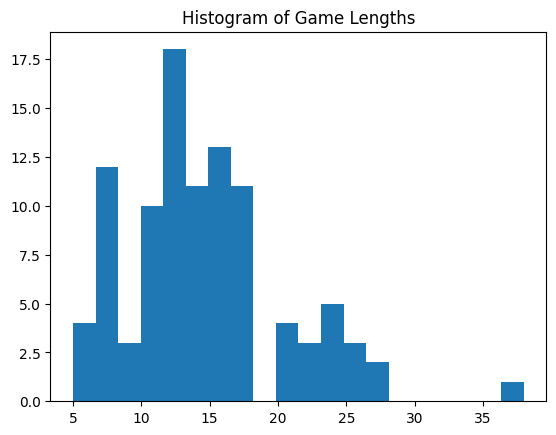

In [49]:
attacker=Leif(3,10,10,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
defender=Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])

nb_runs=100
defender_wins, attacker_wins, avg_length, lengths = runGames(attacker, defender, nb_runs)

print('Defender Score: '+str(100*defender_wins/nb_runs)+' %')
print('Attacker Score: '+str(100*attacker_wins/nb_runs)+' %')
print('Average game length: '+str(round(avg_length,4))+' moves')
plt.hist(lengths, bins=20)
plt.title('Histogram of Game Lengths')
plt.show()

### Some Constants

In [13]:
discount=0.99
n_bootstrap=10

### Board Bin

In [14]:
class BoardBin():

    def __init__(self, size):
        self.bbin=np.zeros((size,51))
        self.count=0
        self.size=size

    #add a board to the list, and two more values: the turn, and the outcome
    #these values are set to 20 by default but are meant to be changed
    def addBoard(self, board, turn):
        if self.count>=self.size:
            return 0
        lineboard=np.array(board).flatten()
        line=np.concatenate((lineboard,np.array([20,20])))
        self.bbin[self.count]=line
        self.bbin[self.count][49]=turn
        return self.count

    #add the outcome after placing a board
    def addOutcome(self, outcome):
        if self.count>=self.size:
            return 0
        self.bbin[self.count][50]=outcome
        self.count+=1
        return
    
    #same function, but adding a return. In practice, these functions are used
    #interchangeably
    def addReturn(self, return_):
        if self.count>=self.size:
            return 0
        self.bbin[self.count][50]=return_
        self.count+=1
        return

    #display a board, its turn and its outcome or return
    def dispBoard(self, index):
        for i in range(7):
            print(self.bbin[index][7*i+0:7*i+7])
        print('Turn: '+str(self.bbin[index][49])) 
        print('Final Outcome/Return: '+str(self.bbin[index][50]))

    #return the list of boards
    def getBoards(self):
        new_bbins=copy.deepcopy(self.bbin)
        return new_bbins


Loading the Bins computed before

In [15]:
with open('Games_Bin_679k.pkl', 'rb') as f:
    Games_Bin = pickle.load(f)

### Bin Treatment

The following block rotates each board in the bin until the king is in the upper-left part of the board (or in the center block).
This reduces the overall variance of boards and makes computing weights or analyzing boards much easier using a the database.

Of course, this means that anytime we want to use a model or a database to compute the reward of a move, its corresponding board will need to be rotated as well.

The block also sorts the boards in different bins depending on their turn and king position.

In [16]:

Rotated_Bins=copy.deepcopy(Games_Bin.bbin[:Games_Bin.count,:])
for i in range(Games_Bin.count):
    king_place=np.where(Rotated_Bins[i,:]==2)[0][0]
    if king_place%7<3 and king_place//7>=3:
        Rotated_Bins[i,0:49]=(np.rot90(np.reshape(Rotated_Bins[i,0:49],(7,7)),3)).flatten()
    elif king_place%7>=3 and king_place//7>=4:
        Rotated_Bins[i,0:49]=(np.rot90(np.reshape(Rotated_Bins[i,0:49],(7,7)),2)).flatten()
    elif king_place%7>=4 and king_place//7<4:
        Rotated_Bins[i,0:49]=(np.rot90(np.reshape(Rotated_Bins[i,0:49],(7,7)),1)).flatten()

Binary_Rotated_Bins=copy.deepcopy(Rotated_Bins)

#transform the 3 in -1's to make computations easier for Machine Learning
Binary_Rotated_Bins[Binary_Rotated_Bins==3]=-1

list_of_kingpos=[0,1,2,3,7,8,9,10,14,15,16,17,24]

#Create two sets of bins, that will sort boards by turn and king position
Att_Rotated_Filtered=np.zeros((13,500000,51))
Def_Rotated_Filtered=np.zeros((13,500000,51))
Att_rfcounts=np.zeros((13))
Def_rfcounts=np.zeros((13))

#add each board in the Bin depending on their turn and king position
for j in range(len(Binary_Rotated_Bins)):
    king_pos=np.where(Binary_Rotated_Bins[j]==2)[0][0]
    bin_index=np.where(list_of_kingpos==king_pos)[0]
    if Binary_Rotated_Bins[j,49]==1:
        Def_Rotated_Filtered[bin_index, int(Def_rfcounts[bin_index])]=Binary_Rotated_Bins[j]
        Def_rfcounts[bin_index]+=1
    if Binary_Rotated_Bins[j,49]==-1:
        Att_Rotated_Filtered[bin_index, int(Att_rfcounts[bin_index])]=Binary_Rotated_Bins[j]
        Att_rfcounts[bin_index]+=1

# Feature Building for Machine Learning

The following block of codes builds features from a board. It contains the functions:
- _getNbForks_: this functions returns the number of possible 'forks'. I call 'forks' situations where two corners on the same side of a board are left unprotected by attackers, and the column/row right in front of both of these corners is totally empty. In this situation, if the king manages to get on this row/column, its victory is guaranteed as it will be impossible for the attackers to block both corners in time.
- _getFeaturesFromBoard_: this functions uses the function above, plus other board information, to compute a 12-long feature vector that will be used for machine learning training. Most of the features are the ones used by our original Heuristic agents, with a few additions

In [91]:
#define all possible 4 forks: if all the squares with 1's in one of these forks are filled with 0's in a board, it means a fork is available
forkfilter=[[1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1.]]


def getNbForks(straightboard):
    nbforks=0

    #multiply the board by each fork, see if any forks are available
    for i in range(4):
        if np.sum(np.abs(forkfilter[i]*straightboard))==0:
            nbforks+=1
    return nbforks


def getFeaturesFromBoard(straight_board):

    checks=[[0,1],[0,-1],[1,0],[-1,0]]

    #create the feature vector
    board=np.reshape(straight_board,(7,7))
    features=np.zeros((11))


    whereDef=np.where(np.array(board)==1)
    whereKing=np.where(np.array(board)==2)
    whereAtt=np.where(np.array(board)==-1)
    full_coord=[whereDef[0].tolist()+whereKing[0].tolist()+whereAtt[0].tolist(), whereDef[1].tolist()+whereKing[1].tolist()+whereAtt[1].tolist()]

    king_pos=[whereKing[0].tolist()[0], whereKing[1].tolist()[0]]

    king_surrounded=0
    for j in range(4):
                if 0<=king_pos[0]+checks[j][0]<=6 and 0<=king_pos[1]+checks[j][1]<=6:
                    if board[king_pos[0]+checks[j][0]][king_pos[1]+checks[j][1]]==-1 or [king_pos[0]+checks[j][0],king_pos[1]+checks[j][1]] in [[3,3]]:
                        king_surrounded+=1

    protected=0
    corners=[[1,0],[0,1],[5,0],[0,5],[1,6],[6,1],[5,6],[6,5]]
    for m in range(8):
        if board[corners[m][0]][corners[m][1]]==-1:
            protected+=1

    #compute all the positions that are either on the king's row or column
    king_cross=[]
    for spann in range(7):
        if (king_pos[0]*7+spann)!=(king_pos[0]*7+king_pos[1]):
            king_cross+=[king_pos[0]*7+spann]
        if (spann*7+king_pos[1])!=(king_pos[0]*7+king_pos[1]):
            king_cross+=[spann*7+king_pos[1]]
    king_cross=np.array(king_cross)
    king_corner=np.array(list_of_kingpos)

    corner_density=len(np.where(np.array(straight_board[king_corner])==-1)[0])
    cross_density=len(np.where(np.array(straight_board[king_cross])==-1)[0])

    #features 0 and 1 are the number of defenders and attackers
    features[0]=len(whereDef[0])
    features[1]=len(whereAtt[0])

    #features 2 and 3 are the king-corner and the king-throne distances
    features[2]=min(abs(king_pos[0])+abs(king_pos[1]),abs(king_pos[0])+abs(king_pos[1]-6),abs(king_pos[0]-6)+abs(king_pos[1]),abs(king_pos[0]-6)+abs(king_pos[1]-6))
    features[3]=abs(king_pos[0]-3)+abs(king_pos[1]-3)

    #feature 4 is the number of forks
    features[4]=getNbForks(straight_board)

    #feature 5 is the surroundedness of the king
    features[5]=king_surrounded

    #features 6 and 7 are the vertical+horizontal coverage of defenders and attackers
    features[6]=len(set(whereDef[0].tolist()))+len(set(whereDef[1].tolist()))
    features[7]=len(set(whereAtt[0].tolist()))+len(set(whereAtt[1].tolist()))

    #feature 8 is the number of protected corner-adjacent squares
    features[8]=protected

    #features 9 and 10 are the number of enemies in the king's quarter of the board, and in the king's row+column
    features[9]=corner_density
    features[10]=cross_density

    return features

In [95]:
#create feature bins analogous to the board bins created before
Att_Features_Datasets=np.zeros((13,int(np.max(Att_rfcounts)),12))
Def_Features_Datasets=np.zeros((13,int(np.max(Def_rfcounts)),12))

l=0

#fill the feature bins using the board bins
for i in range(13):
    for j in range(int(np.max([Att_rfcounts[i], Def_rfcounts[i]]))):
        if 2 in Att_Rotated_Filtered[i,j,0:49]:
            Att_Features_Datasets[i,j,:11]=getFeaturesFromBoard(Att_Rotated_Filtered[i,j,0:49])
            Att_Features_Datasets[i,j,11]=Att_Rotated_Filtered[i,j,50]
        if 2 in Def_Rotated_Filtered[i,j,0:49]:
            Def_Features_Datasets[i,j,:11]=getFeaturesFromBoard(Def_Rotated_Filtered[i,j,0:49])
            Def_Features_Datasets[i,j,11]=Def_Rotated_Filtered[i,j,50]

In [96]:
from sklearn.linear_model import LinearRegression

#create a function to train a MLP regression sklearn algorithm on a dataset
#the size and number of all hidden layers we found through trial-and-error
def trainModel(dataset):
    full_count=len(dataset)
    X_train=dataset[:int(0.8*full_count),0:-1]
    y_train=dataset[:int(0.8*full_count),-1]

    linearModel = LinearRegression()
    linearModel.fit(X_train, y_train)

    avg_error=np.zeros((full_count-int(0.8*full_count)))
    for i in range(full_count-int(0.8*full_count)):
        avg_error[i]=np.abs(linearModel.predict(dataset[int(0.8*full_count)+i,0:-1].reshape(1,-1))[0]-dataset[int(0.8*full_count)+i,-1])
    return linearModel, avg_error


In [97]:
#creating all 26 models, for each of the 13 possible king positions for attackers and defenders

Att_mod1, Att_err1=trainModel(Att_Features_Datasets[1,:int(Att_rfcounts[1]),:])
Att_mod2, Att_err2=trainModel(Att_Features_Datasets[2,:int(Att_rfcounts[2]),:])
Att_mod3, Att_err3=trainModel(Att_Features_Datasets[3,:int(Att_rfcounts[3]),:])
print('First row computed (Attacking samples)')

Att_mod4, Att_err4=trainModel(Att_Features_Datasets[4,:int(Att_rfcounts[4]),:])
Att_mod5, Att_err5=trainModel(Att_Features_Datasets[5,:int(Att_rfcounts[5]),:])
Att_mod6, Att_err6=trainModel(Att_Features_Datasets[6,:int(Att_rfcounts[6]),:])
Att_mod7, Att_err7=trainModel(Att_Features_Datasets[7,:int(Att_rfcounts[7]),:])
print('Second row computed (Attacking samples)')

Att_mod8, Att_err8=trainModel(Att_Features_Datasets[8,:int(Att_rfcounts[8]),:])
Att_mod9, Att_err9=trainModel(Att_Features_Datasets[9,:int(Att_rfcounts[9]),:])
Att_mod10, Att_err10=trainModel(Att_Features_Datasets[10,:int(Att_rfcounts[10]),:])
Att_mod11, Att_err11=trainModel(Att_Features_Datasets[11,:int(Att_rfcounts[11]),:])
print('Third row computed (Attacking samples)')

Att_mod12, Att_err12=trainModel(Att_Features_Datasets[12,:int(Att_rfcounts[12]),:])
print('Finished computing (Attacking samples)')

Def_mod0, Def_err0=trainModel(Def_Features_Datasets[0,:int(Def_rfcounts[0]),:])
Def_mod1, Def_err1=trainModel(Def_Features_Datasets[1,:int(Def_rfcounts[1]),:])
Def_mod2, Def_err2=trainModel(Def_Features_Datasets[2,:int(Def_rfcounts[2]),:])
Def_mod3, Def_err3=trainModel(Def_Features_Datasets[3,:int(Def_rfcounts[3]),:])
print('First row computed (Defending samples)')

Def_mod4, Def_err4=trainModel(Def_Features_Datasets[4,:int(Def_rfcounts[4]),:])
Def_mod5, Def_err5=trainModel(Def_Features_Datasets[5,:int(Def_rfcounts[5]),:])
Def_mod6, Def_err6=trainModel(Def_Features_Datasets[6,:int(Def_rfcounts[6]),:])
Def_mod7, Def_err7=trainModel(Def_Features_Datasets[7,:int(Def_rfcounts[7]),:])
print('Second row computed (Defending samples)')

Def_mod8, Def_err8=trainModel(Def_Features_Datasets[8,:int(Def_rfcounts[8]),:])
Def_mod9, Def_err9=trainModel(Def_Features_Datasets[9,:int(Def_rfcounts[9]),:])
Def_mod10, Def_err10=trainModel(Def_Features_Datasets[10,:int(Def_rfcounts[10]),:])
Def_mod11, Def_err11=trainModel(Def_Features_Datasets[11,:int(Def_rfcounts[11]),:])
print('Third row computed (Defending samples)')

Def_mod12, Def_err12=trainModel(Def_Features_Datasets[12,:int(Def_rfcounts[12]),:])
print('Finished computing full database')

First row computed (Attacking samples)
Second row computed (Attacking samples)
Third row computed (Attacking samples)
Finished computing (Attacking samples)
First row computed (Defending samples)
Second row computed (Defending samples)
Third row computed (Defending samples)
Finished computing full database


In [98]:
#creating arrays of models to be used by the algorithm. As there is no model for king position 0 in attackers (because there are no samples), I added a mock element

Def_mods=[Def_mod0, Def_mod1, Def_mod2, Def_mod3, Def_mod4, Def_mod5, Def_mod6, Def_mod7, Def_mod8, Def_mod9, Def_mod10, Def_mod11, Def_mod12]
Att_mods=[[1], Att_mod1, Att_mod2, Att_mod3, Att_mod4, Att_mod5, Att_mod6, Att_mod7, Att_mod8, Att_mod9, Att_mod10, Att_mod11, Att_mod12]

The following blocks save the current model arrays, or load pre-saved ones

In [99]:
file_name = 'Heuristic_Def_mods.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(Def_mods, file)
    print(f'Object successfully saved to "{file_name}"')

file_name = 'Heuristic_Att_mods.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(Att_mods, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "Heuristic_Def_mods.pkl"
Object successfully saved to "Heuristic_Att_mods.pkl"


The following function is the core of the algorithm: it receives a board and the current turn, rotates the board, then uses the appropriate model to compute the model-predicted outcome of this position. 

In [109]:
def predictOutcome(straightboard, turn):

    #set all 3's to -1
    straightboard[straightboard==3]=-1

    #rotate the board 
    king_place=np.where(straightboard==2)[0][0]
    if king_place%7<3 and king_place//7>=3:
        straightboard=(np.rot90(np.reshape(straightboard,(7,7)),3)).flatten()
    elif king_place%7>=3 and king_place//7>=4:
        straightboard=(np.rot90(np.reshape(straightboard,(7,7)),2)).flatten()
    elif king_place%7>=4 and king_place//7<4:
        straightboard=(np.rot90(np.reshape(straightboard,(7,7)),1)).flatten()

    #choose the right model set, and pick the appropriate model depending on the king position
    king_place=np.where(straightboard==2)[0][0]
    bin_index=np.where(list_of_kingpos==king_place)[0][0]
    if turn==1:
        current_model=Def_mods[bin_index]
    elif turn==-1:
        current_model=Att_mods[bin_index]

    #return the score, mutliplied by the turn so it is always positively oriented for the current player
    score=current_model.predict(getFeaturesFromBoard(straightboard).reshape(1,-1))*turn
    return score

In [156]:
def MLHeuristic(board, turn, width=10, mode='Heuristic'):

    #find list of moves
    movelist=listOfMoves(board, turn)
    scores=np.zeros((len(movelist)))

    #return the right response if there are no moves available
    if len(movelist)==0:
        return [[10, 10], [10, 10]]
    if len(movelist)==1:
        return np.array([movelist[0]])

    simu=Game()

    #iterate through every available movement, and simulate it
    for i in range(len(movelist)):
        simu.reset()
        move=movelist[i]
        simu.preloardBoard(board, 1)
        endgame, eaten, newboard = simu.SimuMove(move[0],move[1])

        #return a move if it leads to immediate victory, set it to -20 if it leads to defeat
        if endgame[0]:
            if endgame[1]==turn:
                scores[i]=20
                return move
            else:
                scores[i]=-20
                continue
        
        #use the ML-predicted outcome to compute scores
        scores[i]=predictOutcome(np.array(newboard).flatten(), turn)

    #if mode is set to MC, return the top width moves: this may be useful in case a Monte Carlo implementation is used in the future
    if mode=='MC':
        max_moves=min(len(movelist),width)
        topindicies=np.argpartition(scores, -max_moves)[-max_moves:]
        npmoves=np.array(movelist)
        

    return movelist[np.random.choice(np.flatnonzero(scores == scores.max()))]

The following block defines our Heuristic

In [158]:
class Loki():
    def __init__(self):
        self.simu=Game()

    #simply return the result of the heuristic function above
    def moveChoice(self, board, turn):
        return MLHeuristic(board, turn)

Typical running block

Time 12.750442028045654
Game 50
Defender victory rate over the last 50 games: 0.76
Attacker victory rate over the last 50 games: 0.22
Time 11.431175231933594
Game 100
Defender victory rate over the last 50 games: 0.7
Attacker victory rate over the last 50 games: 0.28
Defender Score: 73.0 %
Attacker Score: 26.0 %
Average game length: 14.66 moves


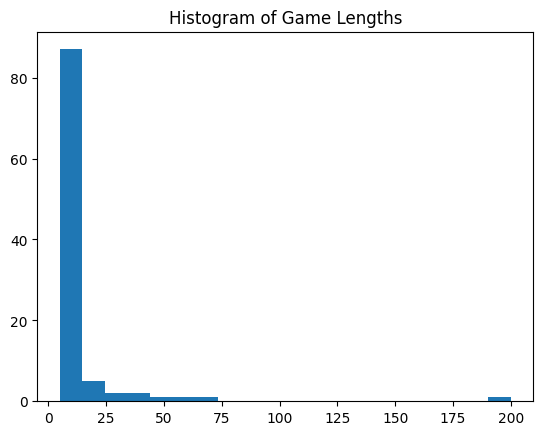

In [159]:
#Leif(3,10,10,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
#Odin(5,5,20,[[0.35, 0.2, 0.35, 0.1],[0.2, 0.1, 0.2, 0.5]])
attacker=Loki()
defender=Loki()

nb_runs=100
defender_wins, attacker_wins, avg_length, lengths = runGames(attacker, defender, nb_runs)

print('Defender Score: '+str(100*defender_wins/nb_runs)+' %')
print('Attacker Score: '+str(100*attacker_wins/nb_runs)+' %')
print('Average game length: '+str(round(avg_length,4))+' moves')
plt.hist(lengths, bins=20)
plt.title('Histogram of Game Lengths')
plt.show()